# Summary of solving phase and frequency matching for $\chi^{(2)}$ nonlinearity, plus interpolation

# Solving phase and frequency matching conditions for $\chi^{(3)}$ with Newton's method

# 2D interpolation for $\chi^{(3)}$.

Here, we use Newton's method to find a set of solutions for a set of equations representing the restrictions on the frequencies for which nonlinear interaction occurs.

In [37]:
import sympy as sp
import numpy as np
import scipy.constants
from sympy.utilities.autowrap import ufuncify
import time
from scipy import interpolate

import matplotlib.pyplot as plt
%matplotlib inline

from sympy import init_printing
init_printing() 

In [295]:
def plot_arr(arr,bounds = None):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111)
    cax = ax.matshow(np.asmatrix(arr), interpolation='nearest')
    fig.colorbar(cax,boundaries = bounds)
    plt.show()

In [39]:
## from https://www.andreas-jung.com/contents/a-python-decorator-for-measuring-the-execution-time-of-methods

def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        print '%r %2.2f sec' % \
              (method.__name__, te-ts)
        return result
    return timed

In [40]:
lambd,omega,omega1,omega2,omega3,omega4 = sp.symbols('lambda omega omega_1 omega_2 omega_3 omega_4')
l2 = lambd **2

def n_symb(pol='o'):
    s = 1.
    if pol == 'o':
        s += 2.6734 * l2 / (l2 - 0.01764)
        s += 1.2290 * l2 / (l2 - 0.05914)
        s += 12.614 * l2 / (l2 - 474.6)
    else:
        s += 2.9804 * l2 / (l2 - 0.02047)
        s += 0.5981 * l2 / (l2 - 0.0666)
        s += 8.9543 * l2 / (l2 - 416.08)
    return sp.sqrt(s)

def k_symb(symbol=omega,pol='o'):
    '''k is accurate for omega inputs between 6-60.'''
    return ((n_symb(pol=pol) * symbol )
                .subs(lambd,scipy.constants.c / (symbol*1e7))) ## / scipy.constants.c

def make_newton_update_expression(dispersion_difference_function,symbols):
    expression_diff = [sp.diff(dispersion_difference_function,sym) for sym in symbols]
    return [- dispersion_difference_function / der for der in expression_diff]

dispersion_difference_function = k_symb()
update_expression = make_newton_update_expression(dispersion_difference_function.expand(),symbols=[omega])

In [41]:
## Let's get an estimate for how long it takes to call the Newton's function, in comparison to calling
## a trivial function

@timeit
def trivial_func():
    f = ufuncify( [omega] , 0.)
    for i in xrange(int(1e6)):
        f(10.)
        return

@timeit
def newton_update_func():
    f = ufuncify( [omega] , update_expression)
    for i in xrange(int(1e6)):
        f(10.)
    return

print "calling 1e6 trivial functions: "
trivial_func()

print "calling 1e6 newton's functions: "
newton_update_func()

calling 1e6 trivial functions: 
'trivial_func' 0.57 sec
calling 1e6 newton's functions: 
'newton_update_func' 1.25 sec


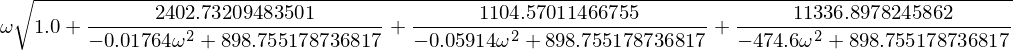

In [42]:
dispersion_difference_function.expand()

In [43]:
k_o_vs_omega = ufuncify([omega],k_symb())
k_e_vs_omega = ufuncify([omega],k_symb(pol='e'))

### $\chi^{(2)}$ example, see also the notebook Dispersion_relation_chi_2_and_interpolations.

In [46]:
dispersion_difference_function = k_symb(omega1,pol='o')+k_symb(omega2,pol='o')+k_symb(omega3,pol='e')

symbols=[omega1,omega2]
update_expression = make_newton_update_expression(dispersion_difference_function.expand(),
                                                    symbols=[omega1,omega2,omega3])

update_expression = [ex.subs(omega3,-omega1-omega2) for ex in update_expression]

In [53]:
newton_update_func_0 = ufuncify( symbols , update_expression[0])
newton_update_func_1 = ufuncify( symbols , update_expression[1])
newton_update_func_2 = ufuncify( symbols , update_expression[2])

omegas_dict = {}

ind_range = range(2,5)
for i in ind_range:
    omegas_dict[i] = np.asarray([6.+ j*5*pow(10,-i) for j in range(1+pow(10,i))])

def trace_omegas(omegas,arg2 = 24.):
    '''
    Trace through triples of frequencies constrained by 
    :math:`omega1+omega2+omega3 = 0`.
    
    At each step of incrementing omega1, find the new omega2 
    and omega3 by applying Newton's method to omega2 
    and the constraint to obtain omega3.
    
    
    Trace through the omegas, when finding the next
    step with Newton's method occasionally check the error 
    and allow terminating early.
    
    Args:
        omegas (list of floats):
            The frequencies in the range desired
        fixed_omega_3 (optional [float]): initial value of omega3.
        
    Returns:
        oms (list of floats): A history of the Newton's steps
        converged_points (list of tuples): 
    '''
    fixed_omega1=omegas[0]
    omegas_delta = omegas[1]-omegas[0]
    oms = [(fixed_omega1, arg2)]  ## k is accurate for omega inputs between 6-60.
    converged_points = []
    for i in range(int(1e5)):
        arg2 += newton_update_func_1(*(oms[-1]))
        oms.append((omegas[0],arg2))
        if sum([ (oms[-1][i] - oms[-2][i])**2 for i in range(2)]) < omegas_delta * 1e-10 :
            break
    for arg1 in omegas:
        for i in range(50):
            for j in range(10):
                arg2 += newton_update_func_1(*(oms[-1]))
                oms.append((arg1,arg2))
            if sum([ (oms[-1][k] - oms[-2][k])**2 for k in range(2)]) < omegas_delta * 1e-10:
                break
        converged_points.append((arg1,arg2))
    return oms,converged_points

In [72]:
@timeit
def timed_trace_omegas(*args,**kw):
    return trace_omegas(*args, **kw)

@timeit
def interpolate_omegas(omegas_few,omegas_many,omegas_few_values):
    f = interpolate.UnivariateSpline(omegas_few, omegas_few_values,k=2,s=1e-10)
    return f(omegas_many)

omegas_converged = {}
for i in ind_range:
    print "i = " + str(i)
    omegas_converged[i] = timed_trace_omegas(omegas_dict[i])

i = 2
'timed_trace_omegas' 0.14 sec
i = 3
'timed_trace_omegas' 0.21 sec
i = 4
'timed_trace_omegas' 1.72 sec


In [91]:
omegas_2_converged = {}
for j in ind_range:
    L = range(len(omegas_converged[j][1]))
    omegas_2_converged[j] = [omegas_converged[j][1][i][1] for i in L]

In [95]:
omega_values_interpolated_3_to_4 = interpolate_omegas(omegas_dict[3], 
                                omegas_dict[4],omegas_2_converged[3] )

'interpolate_omegas' 0.01 sec


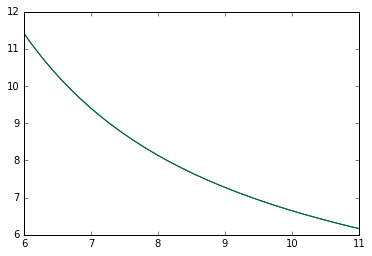

In [103]:
plt.plot(omegas_dict[4],omega_values_interpolated_3_to_4)
plt.plot(omegas_dict[4],omegas_2_converged[4])

In [104]:
om1 = omegas_dict[2][45]
om2 = omegas_2_converged[2][45]
om3 = -sum([om1,om2])
D = { omega1:om1, omega2:om2, omega3:om3 }
dispersion_difference_function.subs(D)

In [105]:
om1,om2,om3

## Four wave mixing ($\chi^{(3)}$) example

In [52]:
dispersion_difference_function_4wv = k_symb(omega1,pol='e')+k_symb(omega2,pol='e')+k_symb(omega3,pol='e')+k_symb(omega4,pol='e')

symbols_4wv=[omega1,omega2,omega3]
update_expression_4wv = make_newton_update_expression(dispersion_difference_function_4wv.expand(),
                                                    symbols=[omega1,omega2,omega3,omega4])
update_expression_4wv = [ex.subs(omega4,-omega1-omega2-omega3) for ex in update_expression_4wv]

newton_update_func_2_4wv = ufuncify( symbols_4wv , update_expression_4wv[2])

diff_disp_4wv = dispersion_difference_function_4wv.subs(omega4,-omega1-omega2-omega3)
func_disp_4wv = ufuncify([omega1,omega2,omega3],diff_disp_4wv)

In [109]:
@timeit
def trace_omegas_four_waves(omegas,omegas_2,arg3_init = -6.):
    '''
    omegas and omegas_2 are the two 'free' axes;
    Their initial values determine omega3 and the implicit omega4.

    Returns:
        converged_dict(dict): maps pairs of frequencies to a third frequency.
        The fourth frequency is determined by minus the sum of the first three.
    '''
    omegas_delta = omegas[1]-omegas[0]
    converged_dict = np.zeros((len(omegas),len(omegas_2)))
    for i1,arg1 in enumerate(omegas): ## to parallelize in the future
        arg3 = arg3_init
        oms = [(arg1,omegas_2[0],arg3 )]
        for i in range(int(1e2)):
            arg3 += newton_update_func_2_4wv(*(oms[-1]))
            oms.append((omegas[0],omegas_2[0],arg3))
            if abs(func_disp_4wv(*oms[-1])) < omegas_delta *1e-5:
                break
        for i2,arg2 in enumerate(omegas_2):
            for i in range(100):
                for j in range(500):
                    arg3 += newton_update_func_2_4wv(*(oms[-1]))
                    oms.append((arg1,arg2,arg3))
                if abs(func_disp_4wv(*oms[-1])) < omegas_delta *1e-3:
                    break
            converged_dict[i1,i2] = arg3
    return converged_dict

@timeit
def interpolate_omegas_4wv(few1,few2,fewz,many1,many2):
    '''
    Interpolation in 3D. The quadratic interpolation wasn't available,
    so I used a cubic interpolation (might be slower).
    '''
    f = interpolate.interp2d(few1,few2,fewz,kind='cubic')
    return f(many1,many2)

#### Let's fix the first axis and see what happens with the rest.

In [110]:
o1 = -15
o2s = np.arange(12,16,0.5)
o3 = np.arange(-23,-6,0.05)
zs = [map( lambda z: func_disp_4wv(o1,o2,z), o3) for o2 in o2s]

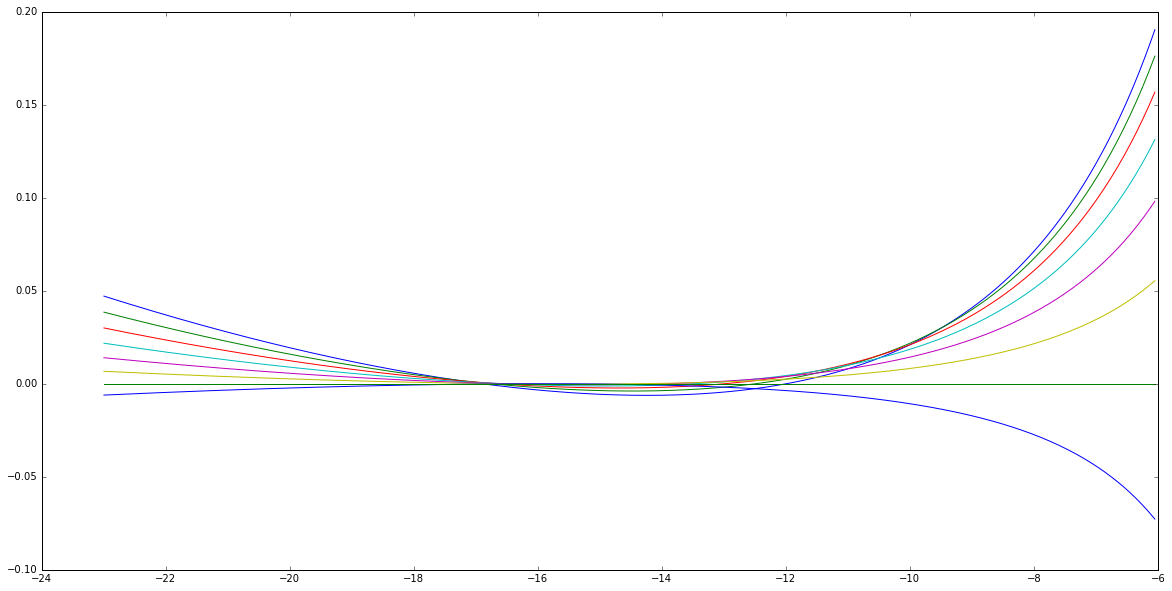

In [111]:
plt.figure(figsize = (20,10))
for z in zs:
    plt.plot(o3,z)
plt.plot(o3,map(lambda z: 0., o3))

In [112]:
## Testing error. All the $k$ functions are the same, so the root should be at (x,y,-y,-x).
func_disp_4wv(15,18,-18)

In [113]:
## Testing the time using other root-finding routines.

In [114]:
from scipy.optimize import brentq
from scipy.optimize import ridder

In [115]:
@timeit
def brent_test(F = lambda z: func_disp_4wv(15,18,z),N = 10000,A=-26,B=-20):
    for i in range(N):
        brentq(F, A, B)

In [116]:
@timeit
def ridder_test(F = lambda z: func_disp_4wv(15,18,z),N = 10000,A=-26,B=-20):
    for i in range(N):
        ridder(F, A, B)

In [117]:
brent_test()

'brent_test' 0.32 sec


In [118]:
brent_test(F = lambda z: z, A = -5,B = 5)

'brent_test' 0.04 sec


In [119]:
brent_test()

'brent_test' 0.32 sec


### Next, let's use the tracing method to find solutions for the matching conditions.

In [120]:
## introduce some displacements to the ranges of omega so we can find solutions

dis1 = 10.
dis2 = 8.

In [155]:
## Trace to find solutions for resolution 2 (101 x 101 grid)

omegas_4wave_converged = {}
omegas_4wave_converged[2] = trace_omegas_four_waves(omegas_dict[2]+dis1,omegas_dict[2]+dis2)

'trace_omegas_four_waves' 21.95 sec


In [125]:
## retrieve the values for all omegas

om1s = omegas_dict[2]+dis1
om2s = omegas_dict[2]+dis2
om3s = omegas_4wave_converged[2]

om4s = np.zeros_like(om3s)
for i in range(len(om1s)):
    for j in range(len(om2s)):
        om4s[i,j] = -om1s[i] - om2s[j] - om3s[i,j]

In [159]:
## sample omegas

i = 43
j = 55

om_ls = om1, om2, om3, om4 = om1s[i], om2s[j], om3s[i,j], om4s[i,j]

print om_ls

(18.149999999999999, 16.75, -7.4333349004664537, -27.466665099533543)


In [160]:
## Error at sample omegas

D = { omega1:om1, omega2:om2, omega3:om3, omega4:om4 }
dispersion_difference_function_4wv.subs(D)

In [161]:
## Find total error

er = 0
for i in range(len(om1s)):
    for j in range(len(om2s)):
        om_ls = om1, om2, om3, = om1s[i], om2s[j], om3s[i,j]
        er += abs(func_disp_4wv(*om_ls))
er

In [162]:
## interpolate to a grid of higher resolution, 101 x 101 -> 1001 x 1001.

interpolated_from_i_to_j = {}
for i,j in [(2,3)]:  ## other combinations could be[(2,3),(3,4),(2,4)]
    interpolated_from_i_to_j[i,j] = interpolate_omegas_4wv(omegas_dict[i]+dis1,omegas_dict[i]+dis2,omegas_3wave_converged[i],
                                          omegas_dict[j]+dis1,omegas_dict[j]+dis2)

'interpolate_omegas_4wv' 0.03 sec


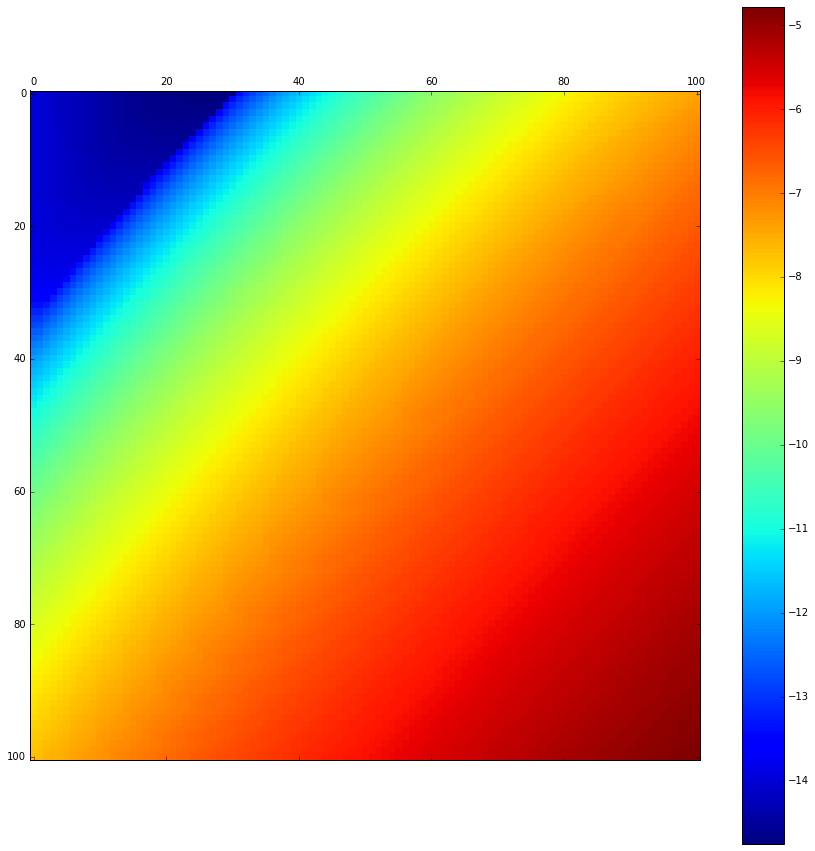

In [134]:
for i in range(2,3):
    plot_arr(omegas_3wave_converged[2])

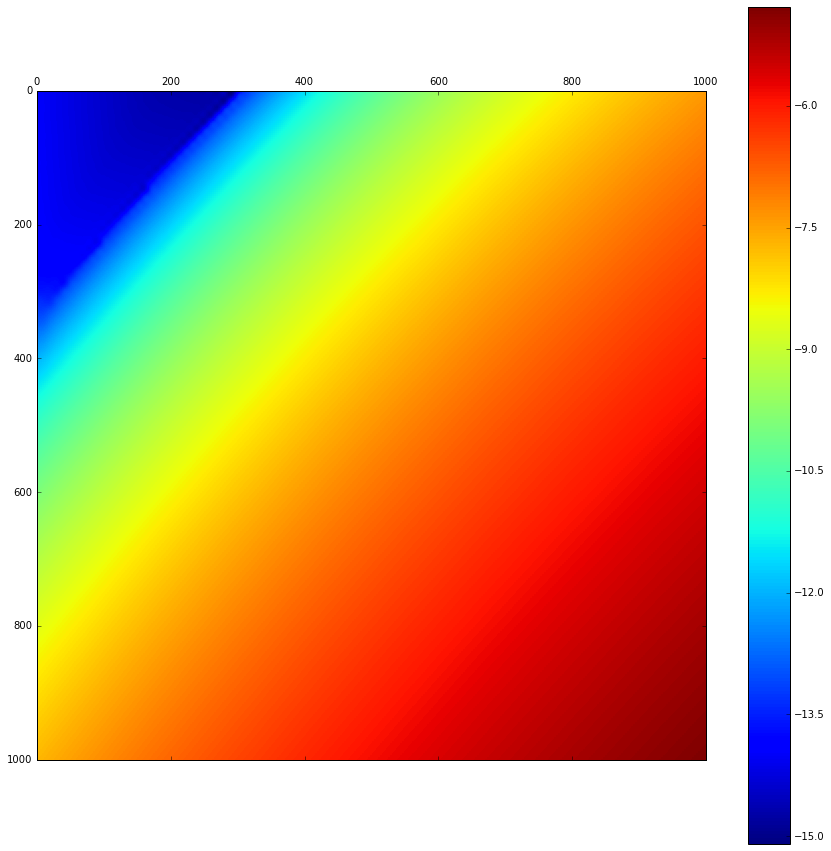

In [135]:
for i,j in [(2,3)]:  ## other combinations could be[(2,3),(3,4),(2,4)]
    plot_arr(interpolated_from_i_to_j[i,j])

In [163]:
### Let's check the error before and after doing the interpolation.

In [251]:
def check_disp_at_freq(om1,om2,i1,i2,arr,printing = False):
    '''
    Function for measuring error
    
    Args:
        om1,om2 (floats):
            values of omega1 and omega2
        i1,i2 (integers): 
            indices of omega1 and omega2
        arr (2D array):
            grid to take two integers and obtain omega3.
    '''
    om4 = - (om1 + om2 + arr[i1,i2])
    if printing:
        print 'omegas are ', om1,om2, arr[i1,i2], om4
    D = {omega1:om1,omega2:om2,omega3:arr[i1,i2],omega4:om4}
    return dispersion_difference_function_4wv.subs(D)

In [254]:
## first set up the grid to the original to see what the error is like at one point

i1 = 73
i2 = 45
om1 = omegas_dict[2][i1] + dis1
om2 = omegas_dict[2][i2] + dis2

arr = omegas_4wave_converged[2]

check_disp_at_freq(om1,om2,i1,i2,arr,printing=True)

omegas are  19.65 16.25 -6.74098429597 -29.159015704


In [256]:
## original grid, evaluate all error values.

err_array = np.zeros((101,101))

for i1 in range(101):
    for i2 in range(101):
        om1 = omegas_dict[2][i1] + dis1
        om2 = omegas_dict[2][i2] + dis2

        arr = omegas_4wave_converged[2]

        err_array[i1,i2] = check_disp_at_freq(om1,om2,i1,i2,arr,printing=False)

In [283]:
## Average error in absolute value for the original grid:
sum(sum(abs(err_array)))/101**2

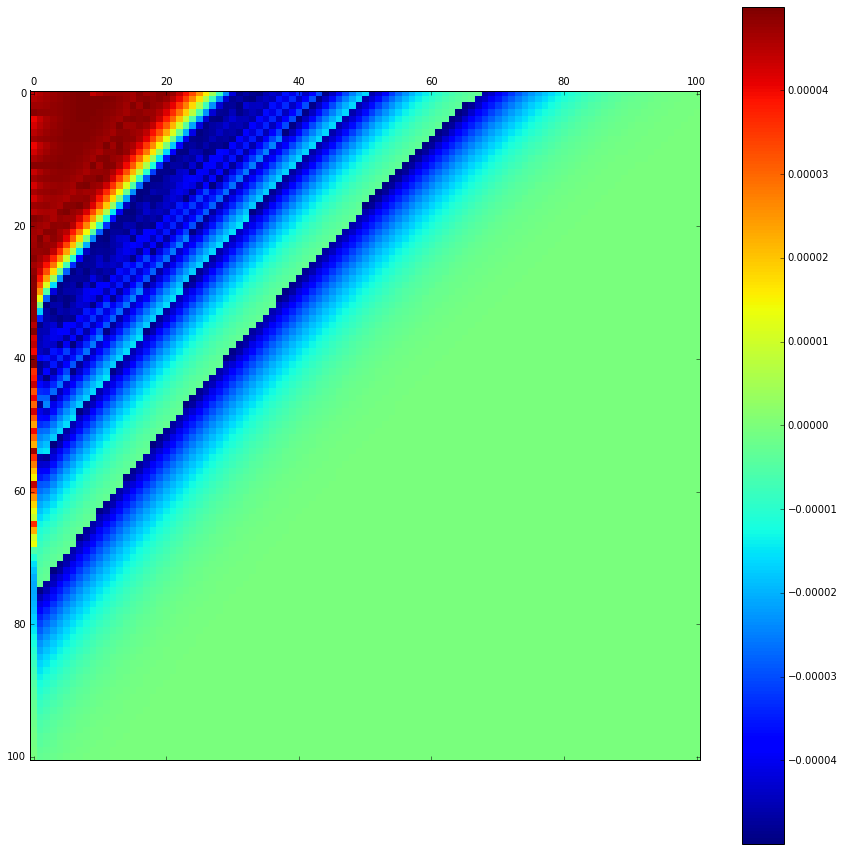

In [264]:
## plot_arrot the error values for the original grid
plot_arr(err_array)

In [259]:
## multiply indices by 10, the dilation factor for the interpolation

i1 = 730
i2 = 450

## higher resolution omegas
om1 = omegas_dict[3][i1] + dis1
om2 = omegas_dict[3][i2] + dis2

## retrieve the interpolated omegas
arr = interpolated_from_i_to_j[2,3]

check_disp_at_freq(om1,om2,i1,i2,arr,printing=True)

omegas are  19.65 16.25 -6.74098429597 -29.159015704


In [276]:
## interpolated grid grid, evaluate error values at the original locations.

err_array_inter_original = np.zeros((101,101))

for i1 in range(101):
    for i2 in range(101):
        i1_inter = 10*i1
        i2_inter = 10*i2
        om1 = omegas_dict[3][i1_inter] + dis1
        om2 = omegas_dict[3][i2_inter] + dis2
        arr = interpolated_from_i_to_j[2,3]

        err_array_inter_original[i1,i2] = check_disp_at_freq(om1,om2,i1_inter,i2_inter,arr,printing=False)

In [284]:
## Average error in absolute value for the interpolated grid at the original points:
sum(sum(abs(err_array_inter_original)))/101**2

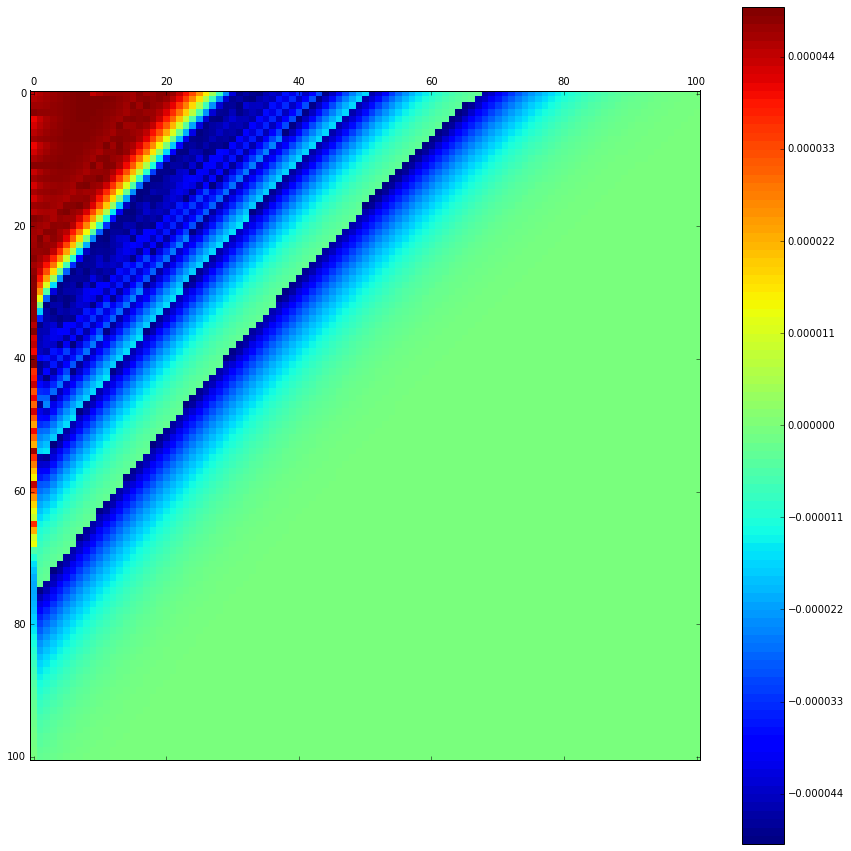

In [322]:
## plot_arrot the error values for the interpolated grid at the original points:
plot_arr(err_array_inter_original,bounds = np.arange(-5e-5,5e-5,1e-6))

In [279]:
## interpolated grid grid, evaluate error values at the original locations.

err_array_inter_between = np.zeros((100,100))

for i1 in range(100):
    for i2 in range(100):
        i1_inter = 10*i1+5
        i2_inter = 10*i2+5
        om1 = omegas_dict[3][i1_inter] + dis1
        om2 = omegas_dict[3][i2_inter] + dis2
        arr = interpolated_from_i_to_j[2,3]

        err_array_inter_between[i1,i2] = check_disp_at_freq(om1,om2,i1_inter,i2_inter,arr,printing=False)

In [285]:
## Average error in absolute value for the interpolated grid at the new points:
sum(sum(abs(err_array_inter_between)))/100**2

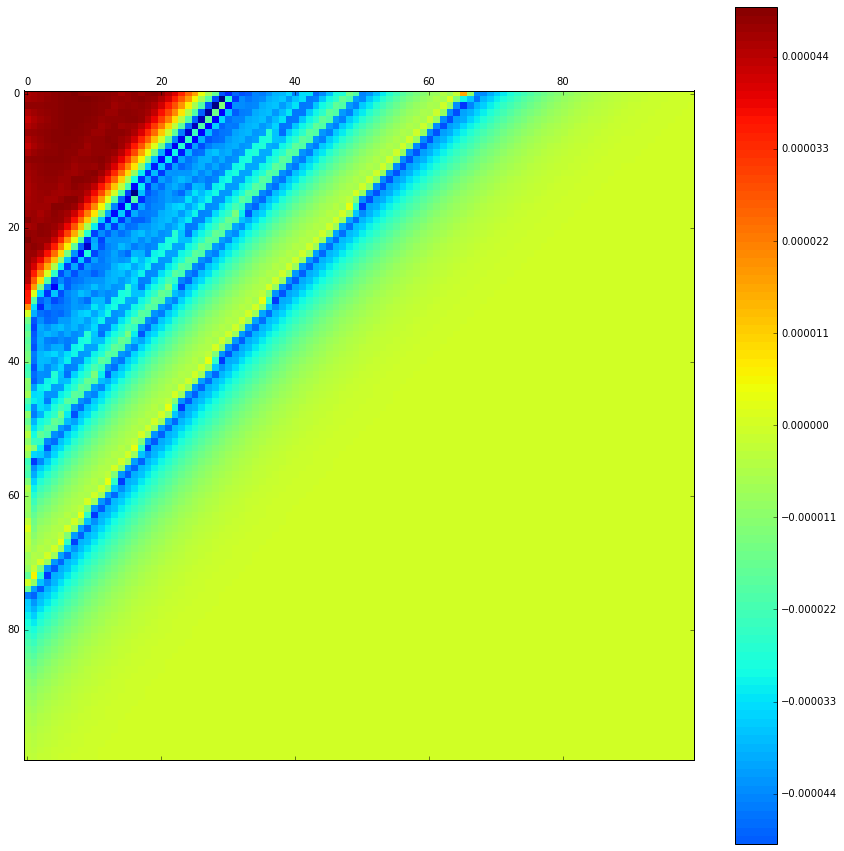

In [323]:
## plot_arrot the error values for the interpolated grid between the original points:
plot_arr(err_array_inter_between,bounds = np.arange(-5e-5,5e-5,1e-6))

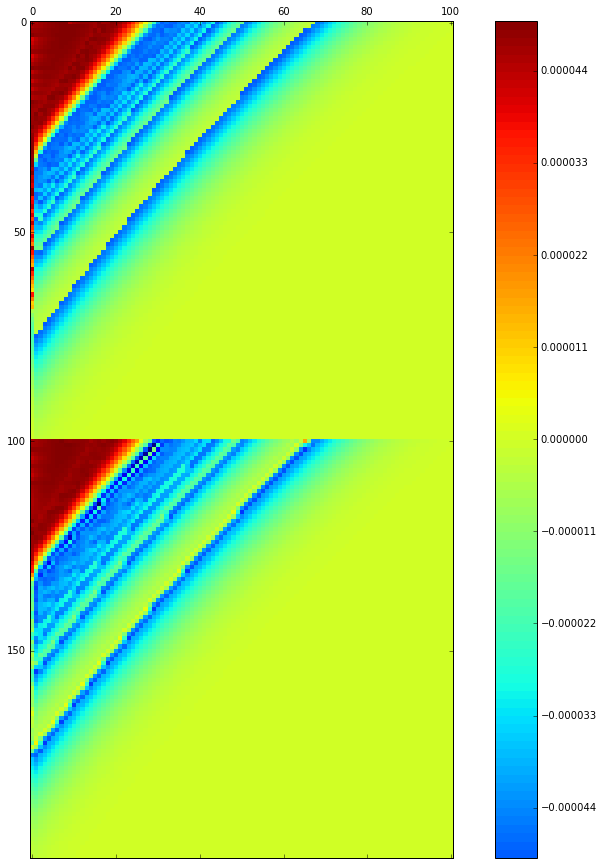

In [345]:
### Let's display both error charts on the same diagram:

big_arr = np.zeros((200,101))

for i in range(101):
    for j in range(101):
        big_arr[i,j] = err_array_inter_original[i,j]
        
for i in range(100):
    for j in range(100):
        big_arr[i+100,j] = err_array_inter_between[i,j]
        
        
plot_arr(big_arr,bounds = np.arange(-5e-5,5e-5,1e-6))

## Conclusion

We see that the error after the intepolation is similar to before, both at the points of interpolation as well as between. 